In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, Activation, Dropout, Add, LSTM, GRU, RNN, LayerNormalization, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam,SGD
import tensorflow as tf
from keras import Model, regularizers, activations
import pickle
from copy import deepcopy

# disable warnings to ignore overflow error
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
# parameters for CSTR
T_0 = 300
V = 1
k_0 = 8.46*(np.power(10,6))
C_p = 0.231
rho_L = 1000
Q_s = 0.0
F = 5
E = 5*(np.power(10,4))
delta_H = -1.15*(np.power(10,4))
R = 8.314
C_A0s = 4

t_final = 0.005
t_step = 1e-4
num_step = 10
num_dims = 4

# parameters for NN
seed = 0
plot = True
rng = np.random.RandomState(seed)
innerepochs = 200 # number of epochs of each inner SGD
ntrain = 32 # size of training minibatches (K)
threshold = 10

In [3]:
def CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial):
    """
        simulating CSTR using forward Euler method
    """

    C_A_list = list()  # evolution of CA over time
    T_list = list()  # evolution of T over time

    C_A = C_A_initial
    T = T_initial

    for i in range(int(t_final / t_step)):
        dCAdt = F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
        dTdt = F / V * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 + Q / (rho_L * C_p * V)

        T += dTdt * t_step
        C_A += dCAdt * t_step

        if i % 5 == 0:
            C_A_list.append(C_A)
            T_list.append(T)

    return C_A_list, T_list

def to_tensor(x):
    return tf.convert_to_tensor(x, dtype=tf.float32)

def train_on_batch(x, y, model, optimizer):
    x = to_tensor(x)
    y = to_tensor(y)

    with tf.GradientTape() as tape:
        YHat = model(x)
        loss = mse_loss_fn(y, YHat)
        grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss

def predict(x, model):
    x = to_tensor(x)
    return model(x).numpy()

def train_on_batch_physics_informed_cstr(x, y, x_all, model, optimizer, scaler_X, scaler_y, F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_step, num_step, num_dims):
    x = to_tensor(x)

    with tf.GradientTape() as tape:
        YHat = model(x)
        YHat_all = model(x_all)
        loss = physics_informed_loss_cstr(x, y, x_all, YHat, YHat_all, scaler_X, scaler_y, F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_step, num_step, num_dims)
        grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss

def physics_informed_loss_cstr(x, y, x_all, yHat, yHat_all, scaler_X, scaler_y, F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_step, num_step, num_dims):
    loss0 = mse_loss_fn(y, yHat)

    x_all = np.array(x_all)
    yHat_all = np.array(yHat_all)

    x_all = scaler_X.inverse_transform(x_all.reshape(-1,num_dims)).reshape(-1,num_step,num_dims)
    yHat_all = scaler_y.inverse_transform(yHat_all.reshape(-1,2)).reshape(-1,num_step,2)

    dCA_first = (yHat_all[:, 1:2, 1] - x_all[:, 0:1, 1]) / (t_step * 6)
    dT_first = (yHat_all[:, 1:2, 0] - x_all[:, 0:1, 0]) / (t_step * 6)

    dCA_center = (yHat_all[:, 2:, 1] - yHat_all[:, :-2, 1]) / (2 * t_step * 10)
    dT_center = (yHat_all[:, 2:, 0] - yHat_all[:, :-2, 0]) / (2 * t_step * 10)

    dCA_last = (yHat_all[:, -1:, 1] - yHat_all[:, -2:-1, 1]) / (t_step * 5)
    dT_last = (yHat_all[:, -1:, 0] - yHat_all[:, -2:-1, 0]) / (t_step * 5)

    dCA = np.concatenate((dCA_first, dCA_center, dCA_last), 1)
    dT = np.concatenate((dT_first, dT_center, dT_last), 1)

    dCAHat = dCA - F / V * ((x_all[:,:,3] + C_A0s) - yHat_all[:,:,1]) + k_0 * np.exp(-E / (R * yHat_all[:,:,0])) * yHat_all[:,:,1]**2
    loss2 = np.square(dCAHat).mean()

    dTHat = dT - F / V * (T_0 - yHat_all[:,:,0]) + delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * yHat_all[:,:,0])) * yHat_all[:,:,1]**2 - (x_all[:,:,2] + Q_s) / (rho_L * C_p * V)
    loss3 = np.square(dTHat).mean()

    # print(loss0)
    # print(loss2)
    # print(loss3)

    loss = 1e2 * loss0 + 1e-4 * loss2 + 1e-8 * loss3
    return loss

def compute_loss(x, y, model):
    return np.square(predict(x, model) - y).mean()

In [4]:
def gen_cstr(F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step):
    isCorrect = False
    while isCorrect == False:
        T_0_new = T_0
        V_new = V
        F_new = F
        C_A0s_new = C_A0s
        Q_s_new = Q_s
        rho_L_new = rho_L
        C_p_new = C_p
        k_0_new = k_0
        E_new = E
        delta_H_new = delta_H

        # generating inputs and initial states for CSTR, all expressed in deviation form
        u1_list = np.linspace(-3.5, 3.5, 4, endpoint=True)
        u2_list = np.linspace(-5e5, 5e5, 4, endpoint=True)
        T_initial = np.linspace(300, 600, 20, endpoint=True)
        CA_initial = np.linspace(0, 6, 20, endpoint=True)

        # restruture the data
        T_start = list()
        CA_start = list()

        for T in T_initial:
            for CA in CA_initial:
                CA_start.append(CA)
                T_start.append(T)

        CA_start = np.array([CA_start])
        T_start = np.array([T_start])
        x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)

        # get X and y data for training and testing
        CA_output = list()
        T_output = list()
        CA_input = list()
        T_input = list()
        CA0_input = list()
        Q_input = list()

        for u1 in u1_list:
            C_A0 = u1 + C_A0s_new
            for u2 in u2_list:
                Q = u2 + Q_s_new
                for C_A_initial, T_initial in x_deviation:

                    C_A_list, T_list = CSTR_simulation(F_new, V_new, C_A0, k_0_new, E_new, R, T_0_new, delta_H_new, rho_L_new, C_p_new, Q, t_final, t_step, C_A_initial, T_initial)
                    if np.isnan(C_A_list).any() == False and np.isnan(T_list).any() == False and np.isinf(C_A_list).any() == False and np.isinf(T_list).any() == False:
                        CA0_input.append(u1)
                        Q_input.append(u2)
                        CA_input.append(C_A_initial)
                        T_input.append(T_initial)

                        CA_output.append(C_A_list)
                        T_output.append(T_list)

        # regenerate data if requirement is not met
        if len(CA_output) > ntrain:

            # collate input for RNN
            CA0_input = np.array(CA0_input)
            CA0_input = CA0_input.reshape(-1,1,1)

            Q_input = np.array(Q_input)
            Q_input = Q_input.reshape(-1,1,1)

            CA_input = np.array(CA_input)
            CA_input = CA_input.reshape(-1,1,1)

            T_input = np.array(T_input)
            T_input = T_input.reshape(-1,1,1)

            RNN_input = np.concatenate((T_input, CA_input, Q_input, CA0_input), axis=2)
            RNN_input = RNN_input.repeat(num_step, axis=1)

            # collate output for RNN
            CA_output = np.array(CA_output)
            CA_output = CA_output.reshape(-1, num_step, 1)

            T_output = np.array(T_output)
            T_output = T_output.reshape(-1, num_step, 1)

            RNN_output = np.concatenate((T_output, CA_output), axis=2)

            # scale the data
            scaler_X = preprocessing.StandardScaler().fit(RNN_input.reshape(-1, num_dims))
            scaler_y = preprocessing.StandardScaler().fit(RNN_output.reshape(-1, 2))

            X = scaler_X.transform(RNN_input.reshape(-1, num_dims))
            y = scaler_y.transform(RNN_output.reshape(-1,2))

            if np.isnan(X).any() == False and np.isnan(y).any() == False and np.isinf(X).any() == False and np.isinf(y).any() == False and any(abs(i) > threshold for i in y.reshape(-1)) == False:
                isCorrect = True

    print("Number of training samples: ", int(len(X)/num_step))
    return X.reshape(-1,num_step,num_dims), y.reshape(-1,num_step,2), scaler_X, scaler_y, F_new, V_new, C_A0s_new, T_0_new, Q_s_new

In [5]:
# generate task
isOverflow = True
while isOverflow == True:
    try:
        x_all, y_all, scaler_X_cstr, scaler_y_cstr, F_new_cstr, V_new_cstr, C_A0s_new_cstr, T_0_new_cstr, Q_s_new_cstr = gen_cstr(F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step)
        isOverflow = False
    except ValueError:
        pass

# use 1000 data points for training and test it on all data
sample_idx = rng.choice(len(x_all), size=10)
x_train = x_all[sample_idx]
y_train = y_all[sample_idx]

Number of training samples:  6400


In [7]:
class Model(tf.keras.layers.Layer):

    def __init__(self):
        super(Model, self).__init__()

        self.layer_1 = LSTM(512, activation='relu', return_sequences=True)
        self.layer_2 = LSTM(256, activation='relu', return_sequences=True)
        self.layer_3 = LSTM(128, activation='relu', return_sequences=True)
        self.layer_4 = Dense(2, activation='linear')

    def call(self, inputs):
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        return x

model = Model()

# Necessary to create the model's state.
# The model doesn't have a state until it's called at least once.
_ = model(tf.zeros((ntrain, num_step, 4)))

optimizer = tf.keras.optimizers.Adam()
mse_loss_fn = tf.keras.losses.MeanSquaredError()

# train with collocation points
test_loss_pi = np.zeros(innerepochs)

# generate evenly spaced collocation points
x_collocation = []
for i in range(len(x_all)):
  if i % 1 == 0:
    x_collocation.append(x_all[i])

x_collocation = np.array(x_collocation)

# begin batch training
inds = rng.permutation(len(x_train))

for i in range(innerepochs):
    for start in range(0, len(x_train), ntrain):
        mbinds = inds[start:start+ntrain]
        train_on_batch_physics_informed_cstr(x_train[mbinds], y_train[mbinds], x_collocation, model, optimizer, scaler_X_cstr, scaler_y_cstr, F_new_cstr, V_new_cstr, C_A0s_new_cstr, k_0, E, R, T_0_new_cstr, delta_H, rho_L, C_p, Q_s_new_cstr, t_step, num_step, num_dims)

    test_loss_pi[i] = compute_loss(x_all, y_all, model)
    print("Test loss: ", test_loss_pi[i])

Test loss:  0.9835557268880792
Test loss:  0.953615717671089
Test loss:  0.9232715337548941
Test loss:  0.8900161403883082
Test loss:  0.8519608523925553
Test loss:  0.8086326215966593
Test loss:  0.7636718795368346
Test loss:  0.7306351782825217
Test loss:  0.7042675611641103
Test loss:  0.778494561176209
Test loss:  0.8922796755396736
Test loss:  0.7993825784501443
Test loss:  0.6915376774725492
Test loss:  0.6307472337394624
Test loss:  0.6006641295986206
Test loss:  0.5844933725008488
Test loss:  0.5738445533791292
Test loss:  0.5638360409413543
Test loss:  0.5518029314553564
Test loss:  0.5387132712473945
Test loss:  0.5270836664217462
Test loss:  0.5183652002373105
Test loss:  0.512702537466417
Test loss:  0.5091026465402059
Test loss:  0.5046768559366602
Test loss:  0.4967327482443452
Test loss:  0.4860930969625736
Test loss:  0.47575448408656945
Test loss:  0.46775557435396115
Test loss:  0.46222397242713287
Test loss:  0.45775361479507204
Test loss:  0.4529481878337575
Test lo

In [9]:
class Model(tf.keras.layers.Layer):

    def __init__(self):
        super(Model, self).__init__()

        self.layer_1 = LSTM(512, activation='relu', return_sequences=True)
        self.layer_2 = LSTM(256, activation='relu', return_sequences=True)
        self.layer_3 = LSTM(128, activation='relu', return_sequences=True)
        self.layer_4 = Dense(2, activation='linear')

    def call(self, inputs):
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        return x

model = Model()

# Necessary to create the model's state.
# The model doesn't have a state until it's called at least once.
_ = model(tf.zeros((ntrain, num_step, 4)))

optimizer = tf.keras.optimizers.Adam()
mse_loss_fn = tf.keras.losses.MeanSquaredError()

# normal training
test_loss = np.zeros(innerepochs)

# begin batch training
inds = rng.permutation(len(x_train))

for i in range(innerepochs):
    for start in range(0, len(x_train), ntrain):
        mbinds = inds[start:start+ntrain]
        train_on_batch(x_train[mbinds], y_train[mbinds], model, optimizer)

    test_loss[i] = compute_loss(x_all, y_all, model)
    print("Test loss: ", test_loss[i])

Test loss:  0.9728129330229466
Test loss:  0.9403587083005543
Test loss:  0.9062669769286474
Test loss:  0.8683067146938058
Test loss:  0.8249369368081324
Test loss:  0.7766270560800258
Test loss:  0.7286293442652452
Test loss:  0.6964274982649324
Test loss:  0.674614589465332
Test loss:  0.7467712632136785
Test loss:  0.7508176864148743
Test loss:  0.6788345461976103
Test loss:  0.6185196610349064
Test loss:  0.5859459852328114
Test loss:  0.57036294380709
Test loss:  0.5614369026122045
Test loss:  0.5528459912178035
Test loss:  0.5414589748815998
Test loss:  0.5279400909505715
Test loss:  0.5148632080662259
Test loss:  0.5033974440397089
Test loss:  0.49378510683242827
Test loss:  0.48666270602232226
Test loss:  0.4818089749016575
Test loss:  0.47699142641347964
Test loss:  0.4699089097780058
Test loss:  0.4609557872866223
Test loss:  0.4517491057989466
Test loss:  0.44380892799872934
Test loss:  0.4384417774226464
Test loss:  0.43507010670575197
Test loss:  0.43180829271726234
Test 

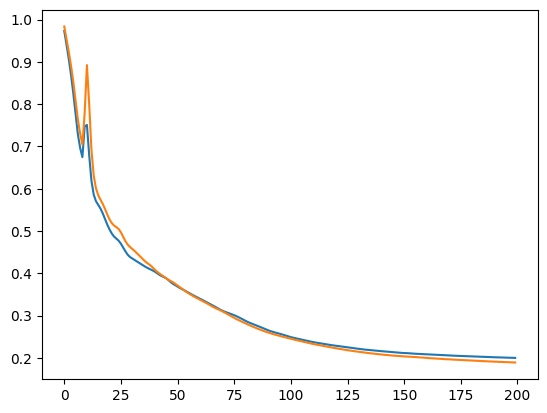

In [10]:
plt.plot(test_loss)
plt.plot(test_loss_pi)
plt.show()